In [1]:
import os as os
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import datetime as dt
plt.style.use('seaborn-whitegrid')

plt.rcParams['image.cmap'] = 'blue'

#sns.set_context('notebook',font_scale=2)
sns.set_style("whitegrid")
% matplotlib inline

In [2]:
taxidata = pd.read_csv('data/oneweekfrom20130107.csv', parse_dates=True)

In [3]:
taxidata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265929 entries, 0 to 3265928
Data columns (total 21 columns):
Unnamed: 0            int64
Unnamed: 0.1          int64
medallion             int64
hack_license          int64
vendor_id             object
rate_code             int64
store_and_fwd_flag    object
pickup_datetime       object
dropoff_datetime      object
passenger_count       int64
trip_time_in_secs     int64
trip_distance         float64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
payment_type          object
pfare_amount          float64
surcharge             float64
tip_amount            float64
total_amount          float64
dtypes: float64(9), int64(7), object(5)
memory usage: 523.3+ MB


So parsing doe not work, do it manually:

In [4]:
taxidata['pickup_datetime'] =pd.to_datetime(taxidata['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
taxidata['dropoff_datetime'] =pd.to_datetime(taxidata['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')

In [5]:
taxidata.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,3265929.0,4.235736e+06,942792.637992,2.602772e+06,3.419254e+06,4.235736e+06,5.052218e+06,5.868700e+06
Unnamed: 0.1,3265929.0,4.235737e+06,942792.637992,2.602773e+06,3.419255e+06,4.235737e+06,5.052219e+06,5.868701e+06
medallion,3265929.0,2.013006e+09,3662.811412,2.013000e+09,2.013003e+09,2.013006e+09,2.013009e+09,2.013013e+09
hack_license,3265929.0,2.013014e+09,8375.177708,2.013000e+09,2.013007e+09,2.013014e+09,2.013021e+09,2.013030e+09
rate_code,3265929.0,1.033506e+00,0.349912,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.100000e+02
passenger_count,3265929.0,1.684586e+00,1.360830,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.550000e+02
trip_time_in_secs,3265929.0,6.835442e+02,494.571365,0.000000e+00,3.600000e+02,5.560000e+02,8.800000e+02,1.068000e+04
trip_distance,3265929.0,2.759258e+00,3.260096,0.000000e+00,1.010000e+00,1.700000e+00,3.050000e+00,9.960000e+01
pickup_longitude,3265929.0,-7.262467e+01,10.106291,-2.249272e+03,-7.399187e+01,-7.398157e+01,-7.396671e+01,0.000000e+00
pickup_latitude,3265929.0,4.000632e+01,9.333506,-3.547921e+03,4.073537e+01,4.075310e+01,4.076752e+01,3.310365e+03


In [6]:
taxidata.head()

,Unnamed: 0,Unnamed: 0.1,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,...,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,pfare_amount,surcharge,tip_amount,total_amount
0,2602772,2602773,2013001380,2013001377,VTS,1,NaN,2013-01-07,2013-01-07 00:12:00,2,...,4.24,-73.987915,40.754730,-73.957382,40.782902,CSH,13.5,0.5,0.00,14.50
1,2602773,2602774,2013005435,2013005432,VTS,1,NaN,2013-01-07,2013-01-07 00:04:00,3,...,1.51,-73.984917,40.736370,-73.984917,40.736370,CRD,6.0,0.5,1.30,8.30
2,2602774,2602775,2013002440,2013002437,VTS,1,NaN,2013-01-07,2013-01-07 00:15:00,6,...,4.86,-73.988365,40.720261,-73.920486,40.702522,CSH,16.5,0.5,0.00,17.50
3,2602775,2602776,2013007092,2013007088,VTS,1,NaN,2013-01-07,2013-01-07 00:14:00,1,...,6.33,-73.989822,40.702522,-74.009789,40.737411,CRD,20.0,0.5,4.10,25.10
4,2602776,2602777,2013003235,2013003231,VTS,1,NaN,2013-01-07,2013-01-07 00:06:00,1,...,1.70,-74.005730,40.717567,-74.006401,40.739521,CRD,7.0,0.5,1.88,9.88


In [7]:
payments = taxidata.payment_type.value_counts()

In [8]:
payments/len(taxidata)

CRD    0.528261
CSH    0.468309
NOC    0.002203
DIS    0.000782
UNK    0.000446
Name: payment_type, dtype: float64

# <font color = 'red'> Drop NOC, DIS, UNK? </font color>

# <font color = 'blue'>  So thats the statistic about payments. Remember, there are to tips recorded for cash payment. </font color>

We are not interested in the following features (they do not add any further information):

In [9]:
taxidata = taxidata.drop(['Unnamed: 0', 'Unnamed: 0.1','vendor_id', 
               'rate_code', 'store_and_fwd_flag',  'pfare_amount', 'payment_type', 
               'surcharge'], axis=1)

In [10]:
taxidata.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
medallion,3265929.0,2.013006e+09,3662.811412,2.013000e+09,2.013003e+09,2.013006e+09,2.013009e+09,2.013013e+09
hack_license,3265929.0,2.013014e+09,8375.177708,2.013000e+09,2.013007e+09,2.013014e+09,2.013021e+09,2.013030e+09
passenger_count,3265929.0,1.684586e+00,1.360830,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.550000e+02
trip_time_in_secs,3265929.0,6.835442e+02,494.571365,0.000000e+00,3.600000e+02,5.560000e+02,8.800000e+02,1.068000e+04
trip_distance,3265929.0,2.759258e+00,3.260096,0.000000e+00,1.010000e+00,1.700000e+00,3.050000e+00,9.960000e+01
pickup_longitude,3265929.0,-7.262467e+01,10.106291,-2.249272e+03,-7.399187e+01,-7.398157e+01,-7.396671e+01,0.000000e+00
pickup_latitude,3265929.0,4.000632e+01,9.333506,-3.547921e+03,4.073537e+01,4.075310e+01,4.076752e+01,3.310365e+03
dropoff_longitude,3265911.0,-7.257707e+01,10.540788,-2.350956e+03,-7.399115e+01,-7.398001e+01,-7.396381e+01,2.084300e+03
dropoff_latitude,3265911.0,3.997879e+01,8.490421,-3.547921e+03,4.073465e+01,4.075365e+01,4.076839e+01,3.210338e+03
tip_amount,3265929.0,1.269877e+00,2.032800,0.000000e+00,0.000000e+00,9.000000e-01,2.000000e+00,2.000000e+02


# Check for missing and false data:

In [11]:
taxidata.isnull().sum()

medallion             0
hack_license          0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
trip_time_in_secs     0
trip_distance         0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    18
dropoff_latitude     18
tip_amount            0
total_amount          0
dtype: int64

So there is not that much data missing. That's quite surprising, maybe it's wrong.

In [12]:
(taxidata==0).sum()

medallion                  0
hack_license               0
pickup_datetime            0
dropoff_datetime           0
passenger_count           41
trip_time_in_secs       7469
trip_distance          18403
pickup_longitude       59605
pickup_latitude        59102
dropoff_longitude      61733
dropoff_latitude       61229
tip_amount           1584618
total_amount               0
dtype: int64

So we have many zeros in the data. How much percent?

In [13]:
(taxidata==0).sum()/len(taxidata)

medallion            0.000000
hack_license         0.000000
pickup_datetime      0.000000
dropoff_datetime     0.000000
passenger_count      0.000013
trip_time_in_secs    0.002287
trip_distance        0.005635
pickup_longitude     0.018251
pickup_latitude      0.018097
dropoff_longitude    0.018902
dropoff_latitude     0.018748
tip_amount           0.485197
total_amount         0.000000
dtype: float64

# <font color = 'blue' > Most of the zeros are missing data. So flag them as NaN (means also NA) to be consistent! </font color>

In [14]:
taxidata = taxidata.replace(np.float64(0), np.nan);

In [15]:
taxidata.isnull().sum()

medallion                  0
hack_license               0
pickup_datetime            0
dropoff_datetime           0
passenger_count           41
trip_time_in_secs       7469
trip_distance          18403
pickup_longitude       59605
pickup_latitude        59102
dropoff_longitude      61751
dropoff_latitude       61247
tip_amount           1584618
total_amount               0
dtype: int64

Identify the the cases without geo data and remove them from our data to be processed.

In [16]:
anomaly = taxidata.loc[(taxidata['dropoff_longitude'].isnull()) | (taxidata['dropoff_latitude'].isnull()) | 
                       (taxidata['pickup_longitude'].isnull()) | (taxidata['pickup_latitude'].isnull())]
taxidata = taxidata.drop(anomaly.index)

In [17]:
anomaly['flag'] = 'geo_NA'

In [18]:
taxidata.isnull().sum()

medallion                  0
hack_license               0
pickup_datetime            0
dropoff_datetime           0
passenger_count           17
trip_time_in_secs       2144
trip_distance          13098
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
tip_amount           1552688
total_amount               0
dtype: int64

So how many percent of data are left to be processed?

In [19]:
len(taxidata)/(len(taxidata)+len(anomaly))

0.9804744683671935

# <font color = 'blue'> So we only dropped 2% of the data because of missing geo tags. Someone could search the 'anomaly'-data for patterns, e.g. for fraud detection. We are also going to drop all the unrecognized trip_distances because we cannot (exactly) generate them (an approximation would be possible). Missing values in trip_time_in_secs can be generated. </font color>

In [20]:
#taxidata.loc[(taxidata['trip_distance'].isnull())]
#print(len(anomaly))
anomaly = anomaly.append(taxidata.loc[(taxidata['trip_distance'].isnull())])
#anomaly.tail()
#taxidata = taxidata.drop(anomaly.index)

In [21]:
anomaly.tail()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,flag,hack_license,medallion,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,trip_time_in_secs
3265501,2013-01-13 23:57:33,40.710545,-74.013443,NaN,2013007949,2013007953,2.0,2013-01-13 23:57:17,40.710499,-74.013458,14.32,71.62,NaN,16.0
3265507,2013-01-13 23:57:22,40.705894,-74.006660,NaN,2013002046,2013002049,1.0,2013-01-13 23:57:20,40.705894,-74.006660,7.50,60.00,NaN,2.0
3265626,2013-01-13 23:58:00,40.719223,-73.987015,NaN,2013030283,2013010476,1.0,2013-01-13 23:58:00,40.719227,-73.987038,13.00,70.30,NaN,NaN
3265655,2013-01-13 23:58:22,40.739307,-73.979889,NaN,2013007009,2013010587,1.0,2013-01-13 23:58:03,40.739300,-73.979881,NaN,3.50,NaN,18.0
3265707,2013-01-14 00:01:27,40.747421,-73.990158,NaN,2013028238,2013008346,1.0,2013-01-13 23:58:35,40.747421,-73.990158,NaN,90.00,NaN,172.0


In [22]:
#anomaly.iloc[taxidata.loc[(taxidata['trip_distance'].isnull().index]['flag'] = 'trip_dist_NA'
# Be carefol! Do not work on the view but on the data! There is a difference between [col1, col2] and [col1][col2]!
anomaly.loc[taxidata.loc[(taxidata['trip_distance'].isnull())].index,'flag'] = 'trip_dist_NA'

In [23]:
anomaly.tail()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,flag,hack_license,medallion,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,trip_time_in_secs
3265501,2013-01-13 23:57:33,40.710545,-74.013443,trip_dist_NA,2013007949,2013007953,2.0,2013-01-13 23:57:17,40.710499,-74.013458,14.32,71.62,NaN,16.0
3265507,2013-01-13 23:57:22,40.705894,-74.006660,trip_dist_NA,2013002046,2013002049,1.0,2013-01-13 23:57:20,40.705894,-74.006660,7.50,60.00,NaN,2.0
3265626,2013-01-13 23:58:00,40.719223,-73.987015,trip_dist_NA,2013030283,2013010476,1.0,2013-01-13 23:58:00,40.719227,-73.987038,13.00,70.30,NaN,NaN
3265655,2013-01-13 23:58:22,40.739307,-73.979889,trip_dist_NA,2013007009,2013010587,1.0,2013-01-13 23:58:03,40.739300,-73.979881,NaN,3.50,NaN,18.0
3265707,2013-01-14 00:01:27,40.747421,-73.990158,trip_dist_NA,2013028238,2013008346,1.0,2013-01-13 23:58:35,40.747421,-73.990158,NaN,90.00,NaN,172.0


In [24]:
taxidata = taxidata.drop(anomaly.index, errors='ignore') # ignore uncontained labels

In [25]:
taxidata.isnull().sum()

medallion                  0
hack_license               0
pickup_datetime            0
dropoff_datetime           0
passenger_count           15
trip_time_in_secs       1095
trip_distance              0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
tip_amount           1543912
total_amount               0
dtype: int64

In [26]:
1-len(taxidata)/(len(taxidata)+len(anomaly))

0.023536029105348022

We already know that there is some data missing in trip_time_in_secs. Therefore we generate it through the information we have from the pickup- and dropoff-datetimes.

In [27]:
taxidata.loc[taxidata.trip_time_in_secs.isnull()].info()
taxidata.loc[taxidata.trip_time_in_secs.isnull()].iloc[995:1015]
#taxidata.loc[taxidata.trip_time_in_secs.isnull(), 'dropoff_datetime']# - \
#taxidata.loc[taxidata.trip_time_in_secs.isnull(),'pickup_datetime']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1095 entries, 3204 to 3263562
Data columns (total 13 columns):
medallion            1095 non-null int64
hack_license         1095 non-null int64
pickup_datetime      1095 non-null datetime64[ns]
dropoff_datetime     1095 non-null datetime64[ns]
passenger_count      1095 non-null float64
trip_time_in_secs    0 non-null float64
trip_distance        1095 non-null float64
pickup_longitude     1095 non-null float64
pickup_latitude      1095 non-null float64
dropoff_longitude    1095 non-null float64
dropoff_latitude     1095 non-null float64
tip_amount           147 non-null float64
total_amount         1095 non-null float64
dtypes: datetime64[ns](2), float64(9), int64(2)
memory usage: 119.8 KB


,medallion,hack_license,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,tip_amount,total_amount
2944954,2013002518,2013002515,2013-01-13 05:48:00,2013-01-13 05:48:00,5.0,NaN,0.19,-73.949493,40.640923,-73.950829,40.640842,NaN,3.5
2945287,2013001434,2013001431,2013-01-13 05:53:00,2013-01-13 05:53:00,2.0,NaN,0.12,-73.965797,40.650429,-73.965141,40.650688,8.0,48.5
2946076,2013008845,2013028305,2013-01-13 06:04:00,2013-01-13 06:04:00,1.0,NaN,0.01,-73.973885,40.794327,-73.973907,40.794312,NaN,3.0
2946265,2013003719,2013003715,2013-01-13 06:07:00,2013-01-13 06:07:00,1.0,NaN,0.31,-73.972237,40.786392,-73.972733,40.785816,NaN,3.5
2947830,2013002947,2013012377,2013-01-13 06:31:00,2013-01-13 06:31:00,6.0,NaN,0.41,-73.991348,40.755516,-73.989021,40.758438,NaN,4.0
2948743,2013002188,2013001539,2013-01-13 06:43:00,2013-01-13 06:43:00,5.0,NaN,0.34,-73.981628,40.752281,-73.986534,40.749607,NaN,3.5
2949566,2013000141,2013000141,2013-01-13 06:54:00,2013-01-13 06:54:00,5.0,NaN,0.02,-73.966682,40.799030,-73.966682,40.799030,NaN,3.0
2949701,2013000572,2013012260,2013-01-13 06:56:00,2013-01-13 06:56:00,1.0,NaN,0.13,-74.006813,40.735771,-74.007370,40.735626,NaN,3.0
2949782,2013011102,2013014679,2013-01-13 06:57:00,2013-01-13 06:57:00,1.0,NaN,1.95,-73.975067,40.757706,-74.000092,40.758617,NaN,9.5
2950729,2013006669,2013014147,2013-01-13 07:09:00,2013-01-13 07:09:00,1.0,NaN,0.05,-73.973656,40.738422,-73.973656,40.738422,NaN,5.5


We can see via a quick inspection, that the datetimes in pickup and dropoff are equal. So we cannot reproduce the trip times. We can also see that there are trips where the geodata are the same for pickup and dropoff. Is there some fraud going on here? If all that is payed with cash, it could be money laundering. 

# <font color = 'red'> Where trip_time = 0, pickup_geo needs to be the same as dropoff_geo. Is this fulfilled? </font color>

# <font color = 'blue'> This are strange data. Pickup and dropoff are sometimes the same in geodata and in datetime. Furthermore, the total amount shows high variation in the same distance (e.g. 0.01 miles for 57.3\$ and 3.0\$). We'll put all of that in the anomaly-data. </font color>

In [28]:
(taxidata.loc[taxidata.trip_time_in_secs.isnull(), 'dropoff_datetime']- \
taxidata.loc[taxidata.trip_time_in_secs.isnull(),'pickup_datetime']).sum()

Timedelta('0 days 00:24:03')

In [29]:
anomaly = anomaly.append(taxidata.loc[(taxidata['trip_time_in_secs'].isnull())])
anomaly.loc[taxidata.loc[(taxidata['trip_time_in_secs'].isnull())].index,'flag'] = 'trip_time_NA'
taxidata = taxidata.drop(anomaly.index, errors='ignore') # ignore uncontained labels / indices

In [30]:
anomaly.tail()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,flag,hack_license,medallion,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,trip_time_in_secs
3247520,2013-01-13 22:40:00,40.736046,-73.989349,trip_time_NA,2013020834,2013005240,6.0,2013-01-13 22:40:00,40.738895,-73.987343,NaN,4.5,0.44,NaN
3258283,2013-01-13 23:22:00,40.772289,-73.956009,trip_time_NA,2013009929,2013009929,5.0,2013-01-13 23:22:00,40.772316,-73.955986,NaN,3.5,0.08,NaN
3260133,2013-01-13 23:30:00,40.648781,-73.785507,trip_time_NA,2013001165,2013001168,1.0,2013-01-13 23:30:00,40.648514,-73.785347,NaN,3.5,0.04,NaN
3261028,2013-01-13 23:34:00,40.645409,-73.776665,trip_time_NA,2013005170,2013005173,2.0,2013-01-13 23:34:00,40.645367,-73.776627,NaN,3.5,0.05,NaN
3263562,2013-01-13 23:47:00,40.763348,-73.928284,trip_time_NA,2013016853,2013005133,1.0,2013-01-13 23:47:00,40.763344,-73.928284,NaN,3.5,0.04,NaN


In [31]:
1-len(taxidata)/(len(taxidata)+len(anomaly))

0.02387130889863187

# <font color = 'blue'> So all in all, we dropped about 2.4% of the data. </font color>

In [32]:
taxidata.isnull().sum()

medallion                  0
hack_license               0
pickup_datetime            0
dropoff_datetime           0
passenger_count           15
trip_time_in_secs          0
trip_distance              0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
tip_amount           1542964
total_amount               0
dtype: int64

We can deal with that. External investigation of the anomaly is recommended.

# Start validating the non-anomaly data: Valid trip_time, valid distance?

In [33]:
taxidata['diff_calc_rec_time'] = taxidata.dropoff_datetime - taxidata.pickup_datetime - \
    pd.to_timedelta(taxidata['trip_time_in_secs'], unit='s')

In [34]:
taxidata.trip_time_in_secs.describe()

count    3.187967e+06
mean     6.862127e+02
std      4.913252e+02
min      1.000000e+00
25%      3.600000e+02
50%      5.600000e+02
75%      8.830000e+02
max      1.068000e+04
Name: trip_time_in_secs, dtype: float64

Okay, even here we have unreasonable trip_times. We'll identify those trips later via avg_velocity.

In [35]:
taxidata.diff_calc_rec_time.describe()

count                   3187967
mean     0 days 00:00:01.708074
std      0 days 00:11:30.114537
min           -1 days +23:20:13
25%             0 days 00:00:00
50%             0 days 00:00:00
75%             0 days 00:00:01
max            14 days 00:00:34
Name: diff_calc_rec_time, dtype: object

In [36]:
taxidata.trip_time_in_secs.quantile([.0001,.01, .95, .99, .9999])

0.0001       4.0000
0.0100     104.0000
0.9500    1605.0000
0.9900    2465.0000
0.9999    6000.2034
Name: trip_time_in_secs, dtype: float64

# <font color = 'red'> An ECDF with logarithmic scale might be suitable right here for identifying unreasonably small trip_times. Have a look at the average amount per time! </font color>

In [37]:
taxidata['avg_amount_per_minute'] = taxidata.total_amount / (taxidata.trip_time_in_secs / 60.0)

Min:0.0189553496209
Max:6000.0


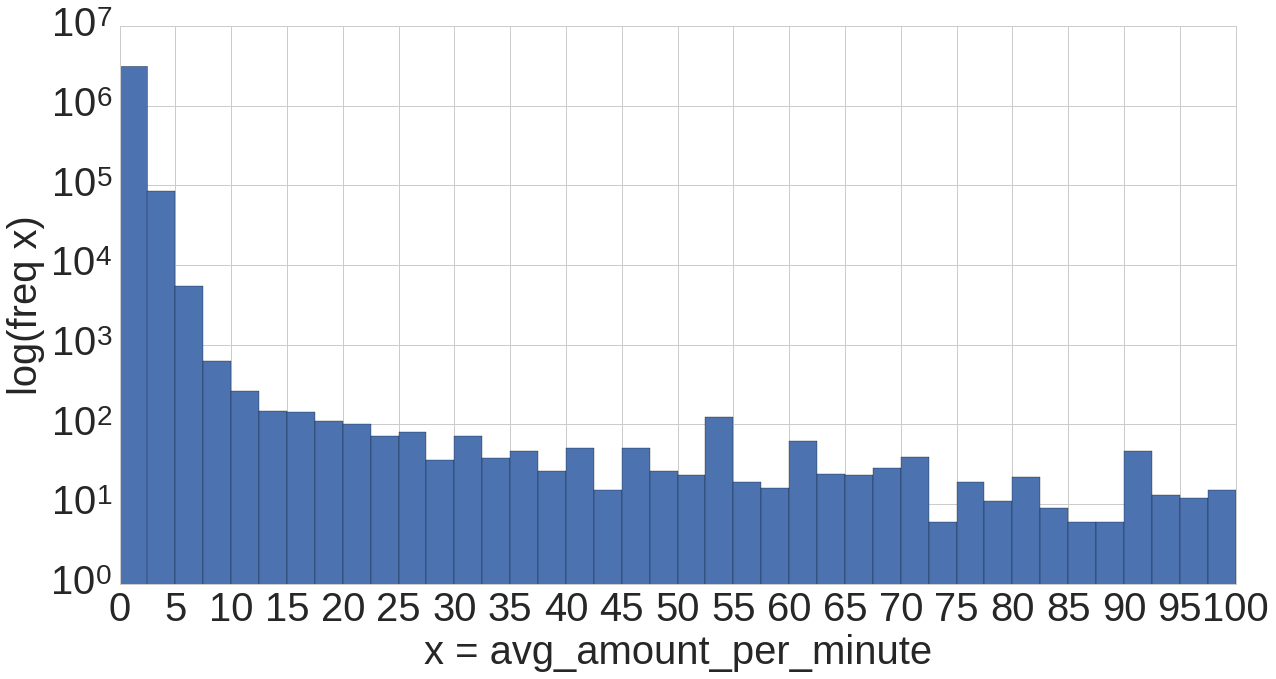

In [38]:
h = taxidata.avg_amount_per_minute
plt.figure(figsize=(20,10))
plt.hist(h, normed=False, stacked=True, bins=40, range=[0 , 100], )
    #, histtype='stepfilled')
plt.yscale('log')
plt.ylabel('log(freq x)', fontsize=40)
plt.xlabel('x = avg_amount_per_minute', fontsize=40)
print('Min:' +  str(min(h)) + '\nMax:' +  str(max(h)))
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
plt.locator_params(axis = 'x', nbins = 20)
plt.show()

In [39]:
taxidata.head()

,medallion,hack_license,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,tip_amount,total_amount,diff_calc_rec_time,avg_amount_per_minute
0,2013001380,2013001377,2013-01-07,2013-01-07 00:12:00,2.0,720.0,4.24,-73.987915,40.754730,-73.957382,40.782902,NaN,14.50,0 days,1.208333
1,2013005435,2013005432,2013-01-07,2013-01-07 00:04:00,3.0,240.0,1.51,-73.984917,40.736370,-73.984917,40.736370,1.30,8.30,0 days,2.075000
2,2013002440,2013002437,2013-01-07,2013-01-07 00:15:00,6.0,900.0,4.86,-73.988365,40.720261,-73.920486,40.702522,NaN,17.50,0 days,1.166667
3,2013007092,2013007088,2013-01-07,2013-01-07 00:14:00,1.0,840.0,6.33,-73.989822,40.702522,-74.009789,40.737411,4.10,25.10,0 days,1.792857
4,2013003235,2013003231,2013-01-07,2013-01-07 00:06:00,1.0,360.0,1.70,-74.005730,40.717567,-74.006401,40.739521,1.88,9.88,0 days,1.646667


In [40]:
taxidata.avg_amount_per_minute.describe()

count    3.187967e+06
mean     1.417456e+00
std      1.000623e+01
min      1.895535e-02
25%      1.003226e+00
50%      1.203209e+00
75%      1.497619e+00
max      6.000000e+03
Name: avg_amount_per_minute, dtype: float64

In [41]:
taxidata.avg_amount_per_minute.quantile([.0001,.01, .95, .99, .995])

0.0001    0.074964
0.0100    0.714286
0.9500    2.186916
0.9900    3.250000
0.9950    4.000000
Name: avg_amount_per_minute, dtype: float64

In [42]:
anomaly = anomaly.append(taxidata.loc[(taxidata['avg_amount_per_minute'] > 2.5)])
anomaly.loc[taxidata.loc[(taxidata['avg_amount_per_minute'] > 2.5)].index,'flag'] = 'too_fast'
taxidata = taxidata.drop(anomaly.index, errors='ignore') # ignore uncontained labels / indices
print(1-len(taxidata)/(len(taxidata)+len(anomaly)))

0.04941779199731533


In [44]:
#anomaly.loc[(anomaly['pickup_datetime'] == anomaly['dropoff_datetime'])].tail(15)
#anomaly.loc[3265892]
anomaly.loc[3212817]

avg_amount_per_minute                    NaN
diff_calc_rec_time                       NaT
dropoff_datetime         2013-01-13 20:36:00
dropoff_latitude                     40.7256
dropoff_longitude                   -74.0052
flag                            trip_time_NA
hack_license                      2013029479
medallion                         2013003292
passenger_count                            1
pickup_datetime          2013-01-13 20:36:00
pickup_latitude                      40.7257
pickup_longitude                    -74.0057
tip_amount                               NaN
total_amount                            52.5
trip_distance                           0.05
trip_time_in_secs                        NaN
Name: 3212817, dtype: object

# <font color = 'red' > Inspect trip amount instead of total amount </font color>

In [39]:
taxidata.avg_amount_per_second.describe()

count    3.187967e+06
mean     2.362426e-02
std      1.667706e-01
min      3.159225e-04
25%      1.672043e-02
50%      2.005348e-02
75%      2.496032e-02
max      1.000000e+02
Name: avg_amount_per_second, dtype: float64

# <font color = 'red'> Use official taxi fares from NYC taxi website </font color>

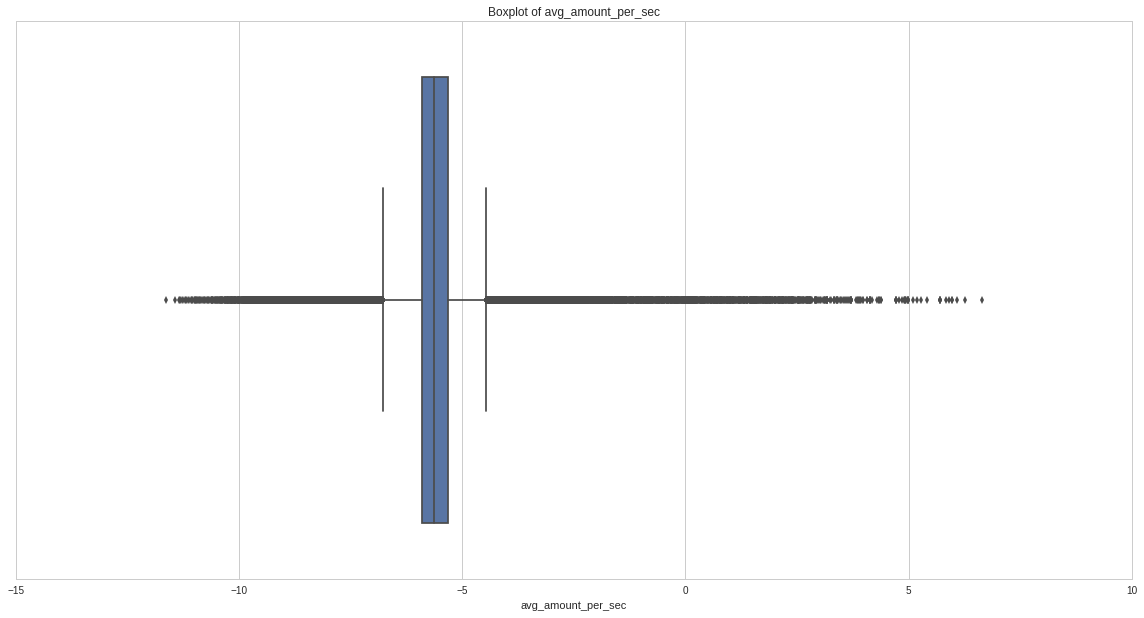

In [49]:
plt.figure(figsize=(20,10))
sns.boxplot(np.log(taxidata.avg_amount_per_second)/np.log(2))
sns.axlabel('avg_amount_per_sec', '')
sns.plt.title('Boxplot of avg_amount_per_sec')

Ok, there are a few outliers! One must decide where the the 'normal' area begins.

# <font color = 'red' > Go on here! Linear Regression might be recommended! Use logarithmic y-axis for the histogram.</font color>

In [41]:
time_diffs = (taxidata.diff_calc_rec_time / np.timedelta64(1,'h')) # display the time diffs in hours

In [43]:
time_diffs.describe()

count    3.187967e+06
mean     4.744650e-04
std      1.916985e-01
min     -6.630556e-01
25%      0.000000e+00
50%      0.000000e+00
75%      2.777778e-04
max      3.360094e+02
Name: diff_calc_rec_time, dtype: float64

Let's make a boxplot out of that:

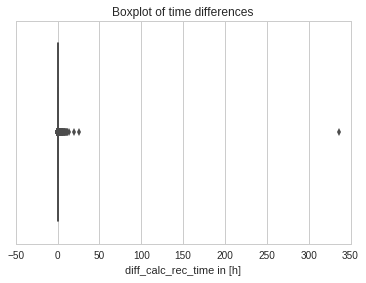

In [56]:
sns.boxplot(time_diffs)
sns.axlabel('diff_calc_rec_time in [h]', '')
sns.plt.title('Boxplot of time differences')

In [57]:
time_diffs.quantile([.0001, .95, .99, .9999])

0.0001   -0.000556
0.9500    0.000278
0.9900    0.000278
0.9999    0.678027
Name: diff_calc_rec_time, dtype: float64

# <font color = blue> Okay, so we have some negative difference right here. We have also unreasonably small trip_times.  But it seems ok in most cases. </font color>

# <font color = 'blue'> So 99% of the differences are less than 0.0003h (i.e. less than 2 seconds). So we cut off all the trips that show more deviation. </font color>

In [44]:
taxidata.loc[(taxidata.diff_calc_rec_time < np.float64(0.0)) | 
              (taxidata.diff_calc_rec_time > np.float64(0.0003))]

TypeError: invalid type comparison

In [ ]:
anomaly.append(taxidata.loc[(taxidata.diff_calc_rec_time < 0) |  (taxidata.diff_calc_rec_time > 0.0003)]

## Calculate average velocity:

In [48]:
taxidata['avg_velo'] = taxidata.trip_distance / (taxidata.trip_time_in_secs / 3600.0)

In [49]:
taxidata.head()

,medallion,hack_license,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,tip_amount,total_amount,diff_calc_rec_time,avg_velo
0,2013001380,2013001377,2013-01-07,2013-01-07 00:12:00,2.0,720.0,4.24,-73.987915,40.754730,-73.957382,40.782902,NaN,14.50,0 days,21.200000
1,2013005435,2013005432,2013-01-07,2013-01-07 00:04:00,3.0,240.0,1.51,-73.984917,40.736370,-73.984917,40.736370,1.30,8.30,0 days,22.650000
2,2013002440,2013002437,2013-01-07,2013-01-07 00:15:00,6.0,900.0,4.86,-73.988365,40.720261,-73.920486,40.702522,NaN,17.50,0 days,19.440000
3,2013007092,2013007088,2013-01-07,2013-01-07 00:14:00,1.0,840.0,6.33,-73.989822,40.702522,-74.009789,40.737411,4.10,25.10,0 days,27.128571
4,2013003235,2013003231,2013-01-07,2013-01-07 00:06:00,1.0,360.0,1.70,-74.005730,40.717567,-74.006401,40.739521,1.88,9.88,0 days,17.000000


In [50]:
taxidata.avg_velo.describe()

count    3.187967e+06
mean     1.472316e+01
std      1.580775e+02
min      3.000000e-02
25%      9.171975e+00
50%      1.204013e+01
75%      1.610000e+01
max      8.496000e+04
Name: avg_velo, dtype: float64

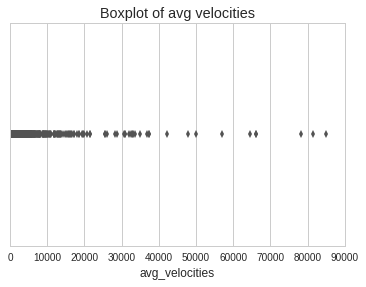

In [57]:
sns.boxplot(taxidata.avg_velo.values)
sns.axlabel('avg_velocities', '')
sns.plt.title('Boxplot of avg velocities')

(array([  3.21807872e-02,   5.46866530e-02,   1.00423592e-02,
          2.51430939e-03,   5.06929873e-04,   4.01777236e-05,
          9.16554321e-06,   7.43915664e-06,   6.71721317e-06,
          5.46165931e-06]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.]),
 <a list of 1 Patch objects>)

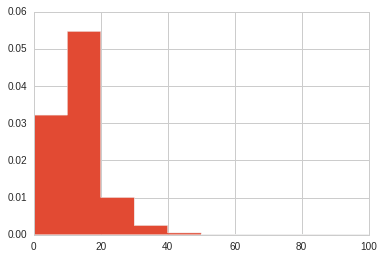

In [80]:
plt.hist(taxidata.avg_velo.values, normed=True, stacked=True, range=[0 ,100.0], histtype='stepfilled')

# <font color = 'red'>Make this a relative frequency!</font color>

In [89]:
taxidata.pickup_latitude.describe()

count    3.202160e+06
mean     4.074874e+01
std      4.588263e+00
min     -3.181078e+03
25%      4.073690e+01
50%      4.075378e+01
75%      4.076790e+01
max      3.210345e+03
Name: pickup_latitude, dtype: float64

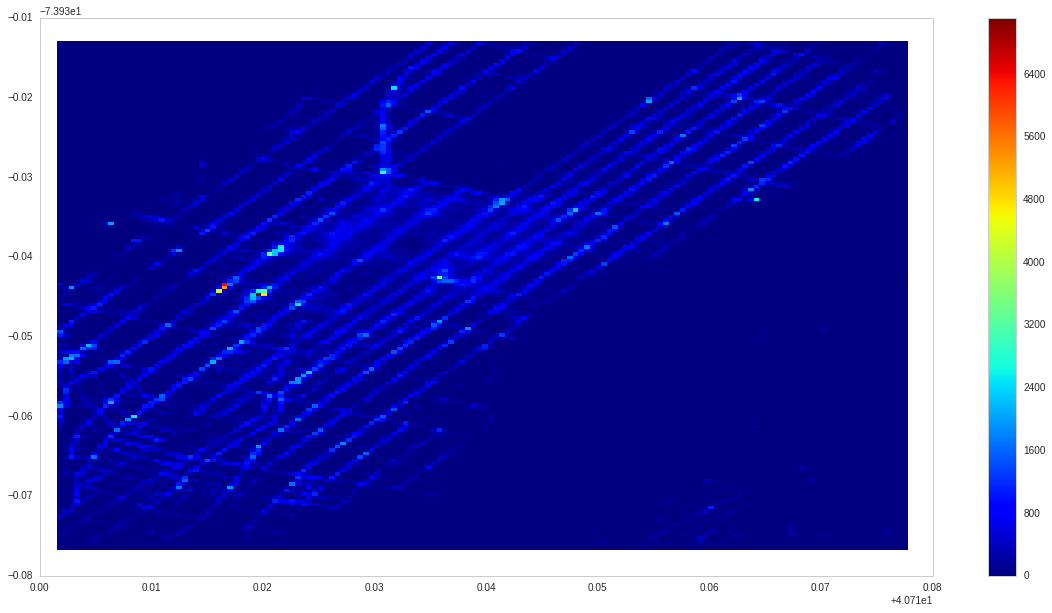

In [48]:
x = taxidata.pickup_latitude
y = taxidata.pickup_longitude

H, xedges, yedges = np.histogram2d(x, y, bins=150, range=[ [x.quantile(.05), x.quantile(.95)], 
        [y.quantile(.05), y.quantile(.95)]], normed=False, weights=None)

plt.jet()
fig = plt.figure(figsize=(20, 10))
#ax.set_title('pcolormesh: exact bin edges')
X, Y = np.meshgrid(xedges, yedges)
mesh = plt.pcolormesh(X, Y, H)
plt.colorbar(mesh)
#ax.set_aspect('equal')
plt.savefig('figure.pdf', format='pdf')
plt.savefig('figure.png', format='png')

In [179]:
type(H)

numpy.ndarray

In [200]:
print(H.shape)
print(H.size)
print(H.max())

(150, 150)
22500
10113.0


In [201]:
indices = np.where(H == H.max())
print(indices)
H[78,28]

(array([78]), array([28]))


10113.0

In [214]:
H_shape = H.reshape(1,150*150)
H_shape.sort()

In [216]:
np.percentile(H_shape, [.5, .7, .8, .9, .95, .9999999])

array([ 0.,  0.,  0.,  0.,  0.,  0.])

In [233]:
print(H_shape)
print(stats.describe(H_shape, axis=1))

[[     0.      0.      0. ...,   6023.   6304.  10113.]]
DescribeResult(nobs=22500, minmax=(array([ 0.]), array([ 10113.])), mean=array([ 118.95875556]), variance=array([ 75596.28880062]), skewness=array([ 6.31623486]), kurtosis=array([ 114.90322824]))


# Ideas: make ndarray to dict (with coordinates), sort according to frequency, check the most frequent places and bring them together with geodata. Apply k-means somewhere?

In [146]:
print(plt.style.available)
plt.colormaps()

['seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'classic', 'bmh', 'seaborn-dark', 'seaborn-deep', 'grayscale', 'seaborn-muted', 'seaborn-poster', 'seaborn-colorblind', 'seaborn-whitegrid', 'seaborn-pastel', 'seaborn-dark-palette', 'seaborn-notebook', 'dark_background', 'seaborn-talk', 'seaborn-bright', 'ggplot', 'seaborn-paper', 'seaborn-white']


['Accent',
 'Accent_r',
 'Blues',
 'Blues_r',
 'BrBG',
 'BrBG_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'CMRmap',
 'CMRmap_r',
 'Dark2',
 'Dark2_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'PRGn',
 'PRGn_r',
 'Paired',
 'Paired_r',
 'Pastel1',
 'Pastel1_r',
 'Pastel2',
 'Pastel2_r',
 'PiYG',
 'PiYG_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuOr',
 'PuOr_r',
 'PuRd',
 'PuRd_r',
 'Purples',
 'Purples_r',
 'RdBu',
 'RdBu_r',
 'RdGy',
 'RdGy_r',
 'RdPu',
 'RdPu_r',
 'RdYlBu',
 'RdYlBu_r',
 'RdYlGn',
 'RdYlGn_r',
 'Reds',
 'Reds_r',
 'Set1',
 'Set1_r',
 'Set2',
 'Set2_r',
 'Set3',
 'Set3_r',
 'Spectral',
 'Spectral_r',
 'Wistia',
 'Wistia_r',
 'YlGn',
 'YlGnBu',
 'YlGnBu_r',
 'YlGn_r',
 'YlOrBr',
 'YlOrBr_r',
 'YlOrRd',
 'YlOrRd_r',
 'afmhot',
 'afmhot_r',
 'autumn',
 'autumn_r',
 'binary',
 'binary_r',
 'bone',
 'bone_r',
 'brg',
 'brg_r',
 'bwr',
 'bwr_r',
 'cool',
 'cool_r',
 'coolwarm',
 'coolwarm_r',
 '


x = taxidata.pickup_latitude
y = taxidata.pickup_longitude


#setup the 2D grid with Numpy
x, y = np.meshgrid(x, y)

#convert intensity (list of lists) to a numpy array for plotting
intensity = np.array(intensity)

#now just plug the data into pcolormesh, it's that easy!
plt.pcolormesh(x, y, intensity)
plt.colorbar() #need a colorbar to show the intensity scale
plt.show() #boom

## here's our data to plot, all normal Python lists

Select one day:

In [31]:
oneday = taxiweek[(taxiweek['pickup_datetime'] > '2013-01-07 00:00') & (taxiweek['pickup_datetime'] < '2013-01-07 23:59')]

In [33]:
oneday.head()

,Unnamed: 0,medallion,hack_license,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,pfare_amount,surcharge,tip_amount,total_amount
91,2602865,2013000476,2013023780,2013-01-07 00:00:01,2013-01-07 00:06:18,1.0,376.0,1.1,-73.968872,40.798531,-73.955879,40.800400,CSH,7.0,0.5,NaN,8.0
92,2602866,2013007185,2013019337,2013-01-07 00:00:01,2013-01-07 00:04:31,1.0,269.0,1.3,-74.001038,40.746243,-74.003067,40.731213,CSH,6.0,0.5,NaN,7.0
93,2602867,2013009072,2013026640,2013-01-07 00:00:04,2013-01-07 00:11:45,1.0,700.0,4.3,-73.956818,40.771019,-73.914642,40.763660,CSH,14.5,0.5,NaN,15.5
94,2602868,2013003999,2013024383,2013-01-07 00:00:04,2013-01-07 00:08:39,1.0,514.0,1.7,-73.971947,40.762646,-73.987793,40.776264,CRD,9.0,0.5,1.0,11.0
95,2602869,2013004328,2013003946,2013-01-07 00:00:04,2013-01-07 00:08:40,1.0,515.0,1.6,-73.974541,40.732578,-73.994499,40.724937,CSH,8.5,0.5,NaN,9.5


(734875.0000115741, 734875.9992939815)

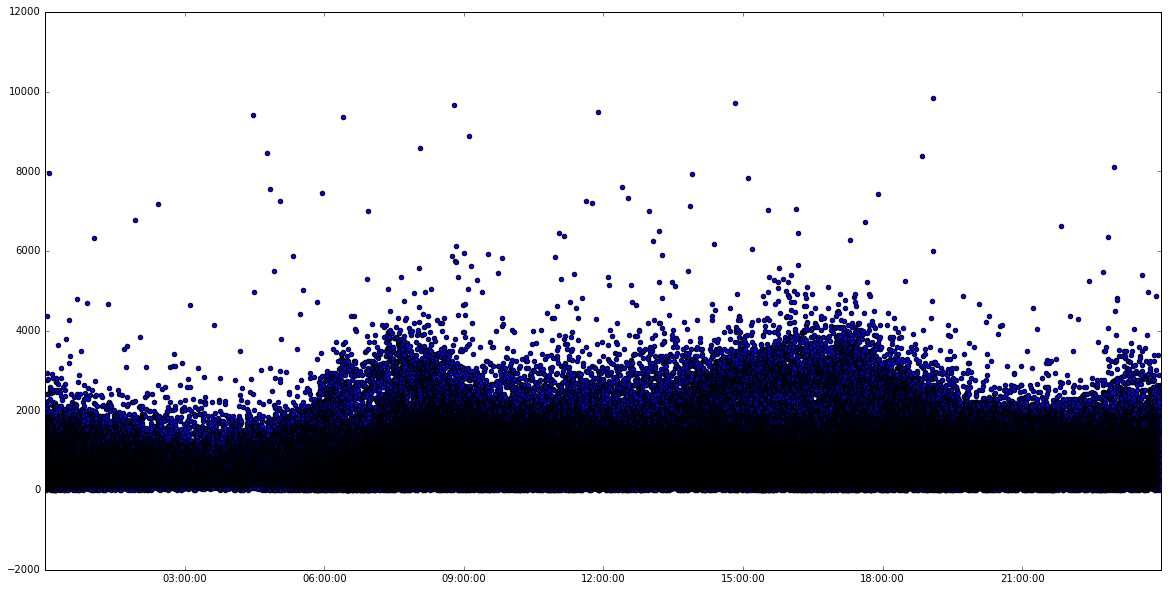

In [40]:
plt.figure(figsize=(20,10))
ax = plt.scatter(oneday.pickup_datetime.values, oneday.trip_time_in_secs.values)
plt.xlim(oneday.pickup_datetime.values.min(), oneday.pickup_datetime.values.max())

(734875.0000115741, 734875.9992939815)

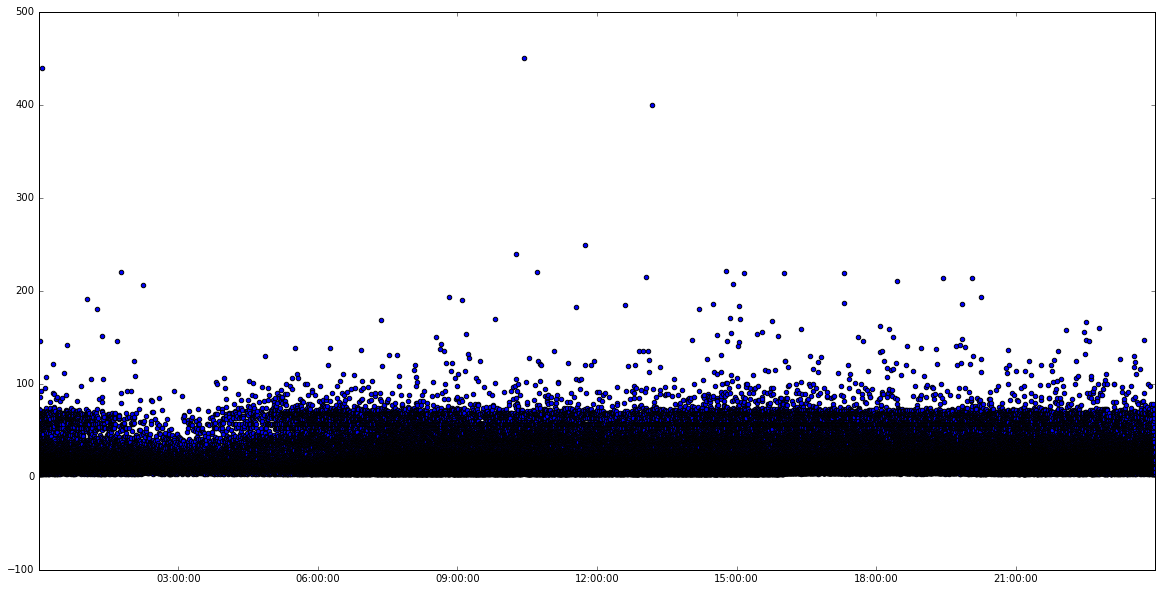

In [41]:
plt.figure(figsize=(20,10))
ax = plt.scatter(oneday.pickup_datetime.values, oneday.total_amount.values)
plt.xlim(oneday.pickup_datetime.values.min(), oneday.pickup_datetime.values.max())